In [35]:
from prophet import Prophet
import os
import pandas as pd
import numpy as np
import datetime, itertools
from prophet.plot import plot_yearly, plot_weekly, plot_plotly, plot_components_plotly
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error

# Transform Data

In [36]:
DATA_DIR = os.path.join("..", "data")
fp = os.path.join(DATA_DIR, "hydrograph-excel-sheet-tp-cleaned.xlsx")
xl = pd.ExcelFile(fp)
gages = xl.sheet_names
hydro_data = {s: xl.parse(s) for s in gages}

In [37]:
def flatten_sheet(sheet_name: str, src_data: dict):
    src_df = src_data[sheet_name]
    
    # Check lengths of columns, some contain only notes so will be
    # much less than 100 and need to be dropped. Most columns
    # should have 365/366 values but a few are missing and need to be filled.
    col_lengths = {c: sum(src_df[c].notna()) for c in src_df.columns}
    keep_cols = [c for c, l in col_lengths.items() if l > 100]
    
    # Check columns are all in the correct order to combine:
    assert "time" in keep_cols[0].lower()
    correct_order = {"time": "ft", "ft": "discharge", "discharge": "time"}
    for i, col in enumerate(keep_cols[:-1]):
        next_col = keep_cols[i+1]
        for key in correct_order.keys():
            if key in col.lower():
                should_be = correct_order[key]
                assert should_be in next_col.lower(), sheet_name
    
    # Iterate through columns and collect data:
    data_subsets = list()
    for start_col in range(0, len(keep_cols), 3):
        df_columns = keep_cols[start_col: start_col+3]
        subset = src_df[df_columns]
        rename = dict(zip(subset.columns, ["time", "ft", "m3"]))
        subset = subset.rename(columns=rename).dropna(how="all")
        data_subsets.append(subset)
        
    # Combine to a single df:
    final =  pd.concat(data_subsets).reset_index(drop=True)
    final["gage"] = sheet_name
    return final

In [38]:
all_sheets = list()
for sname in gages:
    all_sheets.append(flatten_sheet(sname, hydro_data)) 
df = pd.concat(all_sheets).reset_index(drop=True)

In [39]:
min_date, max_date = min(df["time"]), max(df["time"])
all_dates = [min_date.to_pydatetime()]
while all_dates[-1] < max_date:
    all_dates.append(all_dates[-1] + datetime.timedelta(days=1))
    
full_index = list(itertools.product(df["gage"].unique(), all_dates))
df = df.set_index(["gage", "time"])
df = df.reindex(full_index)

In [40]:
gage_list = df.index.get_level_values('gage').unique().tolist()

In [41]:
gage_list

['11402000',
 '11318500',
 '11266500',
 '11208000',
 '11202710',
 '11185500',
 '11189500']

In [42]:
gage_ts = df.loc[gage_list[0]].reset_index(drop = False)
gage_ts.rename(columns = {'time':'ds', 'ft': 'y'}, inplace = True)
min_date = gage_ts['ds'].min()
max_date = gage_ts['ds'].max()

In [43]:
df

ft        m3
gage     time                       
11402000 1984-10-01  54.00  1.529110
         1984-10-02  52.00  1.472476
         1984-10-03  49.00  1.387525
         1984-10-04  49.00  1.387525
         1984-10-05  48.00  1.359209
...                    ...       ...
11189500 2018-09-26   2.86  0.080986
         2018-09-27   2.78  0.078721
         2018-09-28   2.99  0.084667
         2018-09-29   3.12  0.088349
         2018-09-30   3.34  0.094578

[86926 rows x 2 columns]

# Generate Multivariate Time Series Data

In [44]:
gage_df = df.loc[gage_list[0]].reset_index(drop = False)[['time','ft']]
gage_df.rename(columns = {'ft':f'ft_{gage_list[0]}'}, inplace = True)
for gage_num in gage_list[1:]:
    new_gage_df =  df.loc[gage_num].reset_index(drop = False)[['time','ft']]
    new_gage_df.rename(columns = {'ft':f'ft_{gage_num}'}, inplace = True)
    gage_df = gage_df.merge(new_gage_df, on = 'time', how = 'outer')

In [45]:
gage_df.head()

,time,ft_11402000,ft_11318500,ft_11266500,ft_11208000,ft_11202710,ft_11185500,ft_11189500
0,1984-10-01,54.0,10.0,53.0,1.7,NaN,256.0,39.0
1,1984-10-02,52.0,12.0,52.0,1.4,NaN,279.0,42.0
2,1984-10-03,49.0,14.0,51.0,1.4,NaN,284.0,45.0
3,1984-10-04,49.0,13.0,49.0,1.4,NaN,291.0,47.0
4,1984-10-05,48.0,14.0,46.0,1.4,NaN,281.0,50.0


In [49]:
# most 4 years data seems to have no missing values
gage_df.iloc[-365 * 4:].isnull().sum()

time           0
ft_11402000    0
ft_11318500    0
ft_11266500    0
ft_11208000    0
ft_11202710    0
ft_11185500    0
ft_11189500    0
dtype: int64

In [50]:
gage_df = gage_df.iloc[-365 * 4:]

## Baseline Prophet Model

In [28]:
selected_params = {'seasonality_mode':'multiplicative'}
horizon = 30

In [31]:
gage_df.rename(columns = {'time':'ds', 'ft_11402000': 'y'}, inplace = True)
gage_train = gage_df.iloc[: -horizon,:]
gage_test = gage_df.iloc[-horizon:,:]
m = Prophet(**selected_params).fit(gage_train) # **best_params
future = m.make_future_dataframe(periods=horizon)
forecast = m.predict(future)
gage_test['yhat_corrected'] = forecast.iloc[-horizon:]['yhat'].apply(lambda x : max(x,0)).values
gage_test['yhat'] = forecast.iloc[-horizon:]['yhat'].values
forecast['yhat_corrected'] = forecast['yhat'].apply(lambda x : max(x,0))

# gage_test.drop(columns = ['m3'], inplace = True)

# if show_plots:
#     fig1 = m.plot_components(forecast)
#     fig2 = m.plot(forecast)

rmse = np.sqrt(mean_squared_error(gage_test['y'], gage_test['yhat_corrected']))

In [32]:
rmse

22.947919918866564

# Multivariate Seq2Seq Forecasting

In [117]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [86]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [91]:
n_past = 28
n_future = 14 
n_features = 7

In [105]:
len(gage_df[4:]) * 0.8 // 7

166.0

In [144]:
target_gage = '11402000'

In [151]:
train_size = int(len(gage_df[4:]) * 0.8 // 7)
train_df,test_df = gage_df[4:train_size], gage_df[train_size:] 


feature_cols = [f for f in gage_df.columns if 'ft' in f ]

train = train_df[feature_cols]
test = test_df[feature_cols]



In [159]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [164]:
y_train[:,:,0]

array([[ 30. ,  28.6,  27.1, ...,  30.8,  30. ,  28.3],
       [ 28.6,  27.1,  28.6, ...,  30. ,  28.3,  28. ],
       [ 27.1,  28.6,  27. , ...,  28.3,  28. ,  27.6],
       ...,
       [117. , 109. , 104. , ...,  84.1,  80.2,  77.3],
       [109. , 104. ,  98.3, ...,  80.2,  77.3,  75. ],
       [104. ,  98.3,  94.2, ...,  77.3,  75. ,  73. ]])

In [166]:
num_target_col = 1


X_train, y_train = split_series(train.values,n_past, n_future)
y_train = y_train[:,:,0]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], num_target_col))
X_test, y_test = split_series(test.values,n_past, n_future)
y_test = y_test[:,:,0]
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], num_target_col))

In [167]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_target_col))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 7)]      0           []                               
                                                                                                  
 lstm_12 (LSTM)                 [(None, 100),        43200       ['input_5[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_4 (RepeatVector)  (None, 14, 100)     0           ['lstm_12[0][0]']                
                                                                                            

In [168]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=2,callbacks=[reduce_lr])

Epoch 1/25
4/4 - 4s - loss: 207.0541 - val_loss: 301.7996 - lr: 0.0010 - 4s/epoch - 895ms/step
Epoch 2/25
4/4 - 0s - loss: 205.0027 - val_loss: 300.7076 - lr: 9.0000e-04 - 322ms/epoch - 81ms/step
Epoch 3/25
4/4 - 0s - loss: 203.2384 - val_loss: 299.5133 - lr: 8.1000e-04 - 316ms/epoch - 79ms/step
Epoch 4/25
4/4 - 0s - loss: 201.6620 - val_loss: 298.3487 - lr: 7.2900e-04 - 316ms/epoch - 79ms/step
Epoch 5/25
4/4 - 0s - loss: 200.2641 - val_loss: 297.2867 - lr: 6.5610e-04 - 326ms/epoch - 81ms/step
Epoch 6/25
4/4 - 0s - loss: 199.0406 - val_loss: 296.3249 - lr: 5.9049e-04 - 321ms/epoch - 80ms/step
Epoch 7/25
4/4 - 0s - loss: 197.9667 - val_loss: 295.5030 - lr: 5.3144e-04 - 323ms/epoch - 81ms/step
Epoch 8/25
4/4 - 0s - loss: 197.0508 - val_loss: 294.8387 - lr: 4.7830e-04 - 318ms/epoch - 80ms/step
Epoch 9/25
4/4 - 0s - loss: 196.2960 - val_loss: 294.2892 - lr: 4.3047e-04 - 318ms/epoch - 80ms/step
Epoch 10/25
4/4 - 0s - loss: 195.6904 - val_loss: 293.8486 - lr: 3.8742e-04 - 315ms/epoch - 79ms/

In [219]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_target_col))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 28, 7)]      0           []                               
                                                                                                  
 lstm_30 (LSTM)                 [(None, 28, 100),    43200       ['input_10[0][0]']               
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_31 (LSTM)                 [(None, 100),        80400       ['lstm_30[0][0]']                
                                 (None, 100),                                               

In [221]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 0.001 * 0.90 ** x)
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test),batch_size=32,
                            verbose=2,
                            callbacks=[reduce_lr]
                           
                           
                           )

Epoch 1/50
4/4 - 8s - loss: 207.4010 - val_loss: 301.0645 - lr: 0.0010 - 8s/epoch - 2s/step
Epoch 2/50
4/4 - 1s - loss: 204.6772 - val_loss: 298.1414 - lr: 9.0000e-04 - 664ms/epoch - 166ms/step
Epoch 3/50
4/4 - 1s - loss: 201.9614 - val_loss: 295.4402 - lr: 8.1000e-04 - 647ms/epoch - 162ms/step
Epoch 4/50
4/4 - 1s - loss: 200.0234 - val_loss: 293.6553 - lr: 7.2900e-04 - 652ms/epoch - 163ms/step
Epoch 5/50
4/4 - 1s - loss: 198.4533 - val_loss: 292.3246 - lr: 6.5610e-04 - 653ms/epoch - 163ms/step
Epoch 6/50
4/4 - 1s - loss: 197.1731 - val_loss: 291.3375 - lr: 5.9049e-04 - 651ms/epoch - 163ms/step
Epoch 7/50
4/4 - 1s - loss: 196.1783 - val_loss: 290.6245 - lr: 5.3144e-04 - 653ms/epoch - 163ms/step
Epoch 8/50
4/4 - 1s - loss: 195.4269 - val_loss: 290.1049 - lr: 4.7830e-04 - 649ms/epoch - 162ms/step
Epoch 9/50
4/4 - 1s - loss: 194.8558 - val_loss: 289.7147 - lr: 4.3047e-04 - 652ms/epoch - 163ms/step
Epoch 10/50
4/4 - 1s - loss: 194.4127 - val_loss: 289.4130 - lr: 3.8742e-04 - 649ms/epoch - 

In [171]:
pred_e1d1=model_e1d1.predict(X_test)
pred_e2d2=model_e2d2.predict(X_test)

40/40 [==============================] - 1s 12ms/step


In [178]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for index,i in enumerate([target_gage]):
    print(i)
    for j in range(1,6):
        print("Day ",j,":")
        print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index]),end=", ")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index]))
        print("RMSE-E1D1 : ",np.sqrt(mean_squared_error(y_test[:,j-1,index],pred_e1d1[:,j-1,index])),end=", ")
        print("RMSE-E2D2 : ",np.sqrt(mean_squared_error(y_test[:,j-1,index],pred_e2d2[:,j-1,index])))
        
    print()
    print()

11402000
Day  1 :
MAE-E1D1 :  297.9769618008333, MAE-E2D2 :  290.250578287251
RMSE-E1D1 :  803.6363843923265, RMSE-E2D2 :  801.2762807671802
Day  2 :
MAE-E1D1 :  295.59245080911916, MAE-E2D2 :  289.5263081514826
RMSE-E1D1 :  802.4403500935558, RMSE-E2D2 :  801.0282227438339
Day  3 :
MAE-E1D1 :  294.1107213255128, MAE-E2D2 :  289.31910013790997
RMSE-E1D1 :  801.8148975904329, RMSE-E2D2 :  800.9717194068028
Day  4 :
MAE-E1D1 :  293.1807324345856, MAE-E2D2 :  289.24049499295563
RMSE-E1D1 :  801.4857741337978, RMSE-E2D2 :  800.9565979276231
Day  5 :
MAE-E1D1 :  292.5367703472017, MAE-E2D2 :  289.20610580155113
RMSE-E1D1 :  801.3003250474559, RMSE-E2D2 :  800.951813870225




In [183]:
y_test.reshape(y_test.shape[0],y_test.shape[1])

array([[56.5, 49.3, 47.2, ..., 72.2, 80.5, 66.3],
       [49.3, 47.2, 37.4, ..., 80.5, 66.3, 57.6],
       [47.2, 37.4, 38.3, ..., 66.3, 57.6, 52.1],
       ...,
       [15.4, 16.7, 16.4, ..., 23.1, 22.8, 20.9],
       [16.7, 16.4, 15.4, ..., 22.8, 20.9, 17.4],
       [16.4, 15.4, 15.5, ..., 20.9, 17.4, 18.4]])

In [184]:
pred_e1d1.reshape(pred_e1d1.shape[0],pred_e1d1.shape[1])

array([[ 2.8944957,  4.5569706,  6.342183 , ..., 13.40007  , 13.481923 ,
        13.556736 ],
       [ 2.8296351,  4.465993 ,  6.227646 , ..., 13.348536 , 13.439354 ,
        13.51803  ],
       [ 2.6753986,  4.1722727,  5.824697 , ..., 13.22309  , 13.316338 ,
        13.388272 ],
       ...,
       [ 8.4440775, 11.652467 , 13.163033 , ..., 15.257128 , 15.259778 ,
        15.261188 ],
       [ 8.514966 , 11.692306 , 13.180721 , ..., 15.260813 , 15.263212 ,
        15.264516 ],
       [ 8.6357355, 11.781409 , 13.227747 , ..., 15.2690115, 15.271357 ,
        15.272633 ]], dtype=float32)

## Evaluate Results

In [189]:
biweekly_error = []
for pred, ground_truth in zip(pred_e1d1.reshape(pred_e1d1.shape[0],pred_e1d1.shape[1]),
                              y_test.reshape(y_test.shape[0],y_test.shape[1])):
    rmse = np.sqrt(mean_squared_error(pred, ground_truth))
    biweekly_error.append(rmse)

In [194]:
import seaborn as sns

In [205]:
a = [99,4,5,7,0,1]
a.filter(a<5)


AttributeError: 'list' object has no attribute 'filter'

<AxesSubplot:ylabel='Count'>

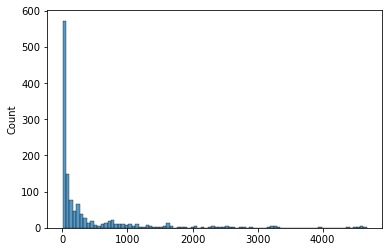

In [206]:
sns.histplot(biweekly_error)

<AxesSubplot:ylabel='Count'>

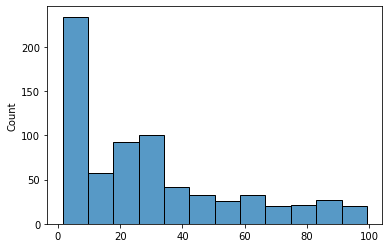

In [209]:
sampled_biweekly_error = [n for n in biweekly_error if n < 100]
sns.histplot(sampled_biweekly_error)

# LSTM

In [66]:
gage_df = df.loc[gage_list[0]].reset_index(drop = False)[['time','ft']]
gage_df.rename(columns = {'ft':f'ft_{gage_list[0]}'}, inplace = True)
for gage_num in gage_list[1:]:
    new_gage_df =  df.loc[gage_num].reset_index(drop = False)[['time','ft']]
    new_gage_df.rename(columns = {'ft':f'ft_{gage_num}'}, inplace = True)
    gage_df = gage_df.merge(new_gage_df, on = 'time', how = 'outer')
    
gage_df = gage_df.iloc[-365 * 4:]

In [69]:
target_col = 'ft_11402000'

In [70]:
gage_df['target'] = gage_df[target_col]

In [71]:
time_shift = 30
target_data = gage_df['target'].shift(time_shift)
data = gage_df.iloc[:-time_shift]

In [72]:
data

,time,ft_11402000,ft_11318500,ft_11266500,ft_11208000,ft_11202710,ft_11185500,ft_11189500,target
10958,2014-10-02,16.6,2.00,11.0,1.5,13.0,0.0,2.27,16.6
10959,2014-10-03,18.0,2.00,10.8,1.4,13.0,0.0,2.21,18.0
10960,2014-10-04,17.3,2.10,10.7,1.5,13.0,0.0,2.20,17.3
10961,2014-10-05,16.0,2.30,10.3,1.5,13.0,0.0,2.22,16.0
10962,2014-10-06,17.4,2.60,10.1,1.5,12.0,0.0,2.16,17.4
...,...,...,...,...,...,...,...,...,...
12383,2018-08-27,17.0,5.82,40.2,4.1,22.0,55.0,2.79,17.0
12384,2018-08-28,19.2,5.72,38.6,4.1,23.0,55.0,2.75,19.2
12385,2018-08-29,18.6,5.87,37.7,4.0,23.0,55.0,2.77,18.6
12386,2018-08-30,20.0,5.94,36.2,4.1,23.0,52.0,2.48,20.0


In [76]:
feature_cols = data.drop(columns = ['time','target']).columns.tolist()
feature_cols

['ft_11402000',
 'ft_11318500',
 'ft_11266500',
 'ft_11208000',
 'ft_11202710',
 'ft_11185500',
 'ft_11189500']

In [73]:
test_head = data.index[int(0.8*len(data))]

df_train = gage_df.loc[:test_head,:]
df_test = gage_df.loc[test_head:,:]
target_train = target_data.loc[:test_head]
target_test = target_data.loc[test_head:]

In [74]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [77]:
i = 27
sequence_length = 7
features = feature_cols
target = 'target'

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[22.5000,  2.6000, 10.6000,  1.4000, 14.0000,  0.0000,  2.6600],
        [22.5000,  2.7000, 10.5000,  1.4000, 13.0000,  0.0000,  3.1500],
        [23.2000,  3.3000, 10.4000,  1.4000, 13.0000,  0.0000,  3.0700],
        [35.5000,  3.7000, 10.5000,  1.5000, 14.0000,  0.0000,  3.0300],
        [35.0000,  3.7000, 10.7000,  1.5000, 14.0000,  0.0000,  3.1500],
        [28.1000,  3.4000, 10.6000,  1.5000, 14.0000,  0.0000,  3.2200],
        [26.3000,  3.2000, 10.7000,  1.5000, 14.0000,  0.0000,  3.2400]])


In [78]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 7, 7])
tensor([[[6.9600e+02, 1.7600e+02, 6.0800e+03, 3.4000e+00, 4.0800e+02,
          5.6500e+02, 1.2500e+03],
         [6.6400e+02, 1.7000e+02, 5.6900e+03, 3.0000e+00, 4.3800e+02,
          5.7600e+02, 1.2400e+03],
         [5.9100e+02, 1.6400e+02, 3.9200e+03, 3.0000e+00, 4.1100e+02,
          5.6000e+02, 1.2300e+03],
         [5.3200e+02, 1.5800e+02, 3.4400e+03, 1.3000e+00, 3.7500e+02,
          5.5300e+02, 1.1600e+03],
         [4.8600e+02, 1.5500e+02, 3.0700e+03, 0.0000e+00, 3.4000e+02,
          5.5000e+02, 1.0800e+03],
         [4.6300e+02, 1.5400e+02, 2.5800e+03, 0.0000e+00, 3.0100e+02,
          5.3000e+02, 1.0200e+03],
         [4.7200e+02, 1.5300e+02, 2.3800e+03, 3.1000e+00, 2.8300e+02,
          5.2700e+02, 9.7500e+02]],

        [[3.6700e+01, 3.8000e+00, 4.0100e+02, 1.1000e+01, 6.1000e+00,
          1.9900e+02, 8.7700e+00],
         [3.8800e+01, 7.8000e+00, 3.7800e+02, 1.1000e+01, 6.3000e+00,
          1.8900e+02, 8.6500e+00],
         [4.4800e+01, 1.6000e+0

In [79]:
batch_size = 4
sequence_length = 7

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 7, 7])
Target shape: torch.Size([4])


In [80]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [81]:
learning_rate = 5e-4
num_hidden_units = 8

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [82]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(30):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 170873.41584797148

Epoch 0
---------
Train loss: 677741.1989021966
Test loss: 170767.7034095088

Epoch 1
---------
Train loss: 677501.5249025564
Test loss: 170605.03493953656

Epoch 2
---------
Train loss: 677299.4300107524
Test loss: 170366.73983841907

Epoch 3
---------
Train loss: 676706.1167311452
Test loss: 170094.44985778423

Epoch 4
---------
Train loss: 676884.1327460951
Test loss: 169811.28410793256

Epoch 5
---------
Train loss: 675669.3594616082
Test loss: 169516.9464481209

Epoch 6
---------
Train loss: 675072.644075799
Test loss: 169140.05310087567

Epoch 7
---------
Train loss: 674459.0158398525
Test loss: 168847.5033165171

Epoch 8
---------
Train loss: 673941.1603868598
Test loss: 168567.038689722

Epoch 9
---------
Train loss: 673500.5841700324
Test loss: 168269.523753637

Epoch 10
---------
Train loss: 673055.2345612955
Test loss: 168014.8466104435

Epoch 11
---------
Train loss: 672818.6869991715
Test loss: 167716.416280167

Epoch 

In [83]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

       target  Model forecast
10958    16.6       18.184389
10959    18.0       18.563141
10960    17.3       18.346769
10961    16.0       18.009441
10962    17.4       18.667486
...       ...             ...
12413    23.1       17.656294
12414    22.8       17.612049
12415    20.9       17.542467
12416    17.4       17.420143
12417    18.4       17.962250

[1461 rows x 2 columns]


<ipython-input-83-eac2ac85467c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[ystar_col] = predict(train_eval_loader, model).numpy()
<ipython-input-83-eac2ac85467c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[ystar_col] = predict(test_loader, model).numpy()


In [84]:
df_out

,target,Model forecast
10958,16.6,18.184389
10959,18.0,18.563141
10960,17.3,18.346769
10961,16.0,18.009441
10962,17.4,18.667486
...,...,...
12413,23.1,17.656294
12414,22.8,17.612049
12415,20.9,17.542467
12416,17.4,17.420143
